In [2]:
%matplotlib inline


def print_tensor(tensor):
    """print main attribute of tensor
    """
    print(f'\
    data: {tensor.data}\n \
    requires_grad: {tensor.requires_grad}\n \
    grad: {tensor.grad}\n \
    grad_fn: {tensor.grad_fn}\n \
    is_leaf: {tensor.is_leaf}\n')


## הקדמה בסיסית `torch.autograd`

`torch.autograd` הוא כלי מיוחד שמאפשר לאמן רשתות נויירונים באופן אוטומטי יחסית. בפרק הזה נסביר איך משתמשים ב `torch.autograd`


### טנזורים ורשת נוירונים _nerual networks_
> רשת נוירונים  _nerual networks (NN)_ היא קבוצה של פונקציות משורשרות אחת בתוך השניה, שמפעילים אותה על מידע _input_ כלשהוא ומצפים ל_outpot_ (תוצאה) נכונה, לדוגמה - אנחנו נרצה רשת נויירונים שנכניס לה תמונה ונקבל תוצאה מה יש בתמונה - כלב או חתול.
רשת הנויירונים  מוגדרות על ידי פרמטרים שנקראים _biases_ ו _weights_ (משקולות) שאותם _PyTorch_  מאחסנת בטנזורים.  


ע"מ שNN יפעל כמו שצריך, כלומר יהיה לנו את ה_weights_ (משקולות) הנכונים, צריך לאמן את הרשת.
אימון הרשת נעשה ע"י _data set_ שזה מידע מתוייג, למשל תמונות שמצורף אלהם תיאור מה יש בתמונה כלב או חתול. את המידע המתוייג נעביר ברשת בשני שלבים:

**פיעפוע לפנים? _Forward Propagation_**
בתהליך זה האלגוריתם לוקח את המשקולות הנתונים לו (בצעד הראשון אלו משקולות אקראיים) ומחשב את התוצאה עבור מידע מסויים. בדוגמה שלנו - נכניס לרשת תמונה ונקבל את התוצאה 

**פיעפוע לאחר _Backward Propagation_**
בתהליך זה האלגוריתם משווה את התוצאה עם התוצאה הידועה לו כנכונה, ומעדכן את המשקולות באופן פפרציונלי לשגיאה. הוא עושה את זה ע"י מעבר אחורה על הפונקציות ושינוי של הפרמטרים שלהם ע"מ שיתקרבו לתשובה הנכונה - ע"י מבט על הנגזרת שלהם. פונקציה זאת נקראת _gradient descent_. ע"מ להבין טוב יותר ניתן לראות את הסרטון [הזה](https://www.youtube.com/watch?v=tIeHLnjs5U8) של _3Blue1Brown_  


 ## אימון עם _PyTorch_


נתבונן על מחזור אימון אחד. 
בדוגמה הזאת נטען מודל מאומן מראש בשם `resnet18` מתוך חבילת המודלים המאומנים `torchvision`. אנחנו ניצור טנזור רנדומלי `data` שייצג תמונה עם 3 ערוצים (RBG), הגובה והרוחב של התמונה הם 64X64 פיקסלים.
לתמונה האקראית ניצור גם `label` אקראי שייצג את מה שיש בתמונה. הצורה של המודלים היא (1,1000) ??

In [2]:
import torch, torchvision
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64) #ramdom image
labels = torch.rand(1, 1000)

נוכל לראות את כל שכבה ואת המאפיינים שלה ע"י מעבר על `()model.named_parameters` (יש המון מידע בשכבות, אז לא כדאי להדפיס את כל המשקלים)
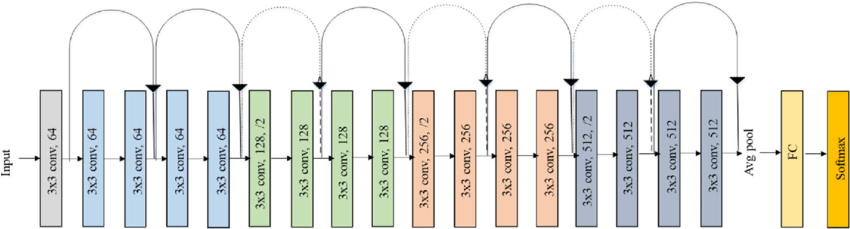

In [3]:
for name, param in model.named_parameters():
    print(name, end = "-> ")
    print(param.requires_grad) #if need to update it in Backward Propagation
#     print(param) #All the weights of the nets, it's huge
    

conv1.weight-> True
bn1.weight-> True
bn1.bias-> True
layer1.0.conv1.weight-> True
layer1.0.bn1.weight-> True
layer1.0.bn1.bias-> True
layer1.0.conv2.weight-> True
layer1.0.bn2.weight-> True
layer1.0.bn2.bias-> True
layer1.1.conv1.weight-> True
layer1.1.bn1.weight-> True
layer1.1.bn1.bias-> True
layer1.1.conv2.weight-> True
layer1.1.bn2.weight-> True
layer1.1.bn2.bias-> True
layer2.0.conv1.weight-> True
layer2.0.bn1.weight-> True
layer2.0.bn1.bias-> True
layer2.0.conv2.weight-> True
layer2.0.bn2.weight-> True
layer2.0.bn2.bias-> True
layer2.0.downsample.0.weight-> True
layer2.0.downsample.1.weight-> True
layer2.0.downsample.1.bias-> True
layer2.1.conv1.weight-> True
layer2.1.bn1.weight-> True
layer2.1.bn1.bias-> True
layer2.1.conv2.weight-> True
layer2.1.bn2.weight-> True
layer2.1.bn2.bias-> True
layer3.0.conv1.weight-> True
layer3.0.bn1.weight-> True
layer3.0.bn1.bias-> True
layer3.0.conv2.weight-> True
layer3.0.bn2.weight-> True
layer3.0.bn2.bias-> True
layer3.0.downsample.0.weight->

בשלב הבא נעביר את הקלט (התמונה האקראית שיצרנו) דרך כל אחת משכבות המודל, נקבל בפלט חיזוי מהו תוכן התמונה.
פלט החיזוי הוא טנזור שמכיל לכל ליבל את הסיכוי שזה הוא. 


In [4]:
prediction = model(data) # forward pass

In [5]:
prediction.shape

torch.Size([1, 1000])

נשווה את מה שהמודל חזה ואת מה שידוע לנו שהיא התוצאה הנכונה. נסכום את ההפרש בינהם וכך נוכל לחשב את שיעור הטעות `loss`.

בשלב הבא נשנה את המשקולות בהתאמה לשגיאה דרך תהליך הפיעפוע לאחור _backward_ 

תהליך הפיעפוע לאחור מתחיל ע"י קריאה למתודה `()backward.` על הטנזור הטעות `loss`. לאחר מכן בצורה אוטומטית _Autograd_ מחשב ומאחסן את הגרדיאנט _gradients_ לכל מודל פרמטר של המודל בתוך המאפיין (_attribute_) `grad.`  של הפרמטר.  
>💡 שימו לב - המתודה `()backward.` נגשת לכל שכבה במודל ומכניסה לה את ערך ה_grad_, למרות שהיא נקראת על טנזור ה_loss_  


In [6]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

בשלב הבא נפעיל את תהליך האופטימיזציה על המודל, במקרה הזה נשתמש ב_SGD_ כך שהפרמטרים _learninig rate_ `lr` הוא 0.01 והמומנטום [_momentum_]((https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) הוא 0.9, נכניס את כל הפרמטרים לתוך האופטימייזר.  


In [7]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

לבסוף קוראים למתודה `()step.` ע"מ להחיל את ה_gradient descent_ על הפרמטרים. האפטימייזר ישנה את הערכים של כל פרמטר ופרמטר לפי הגרינאנט _gradient_ שנמצא ב`grad.`

In [8]:
optim.step() #gradient descent

בשלב הזה סיימנו את כל התהליך של אימון רשת נוירונים. בהמשך הפרק נראה איך הדברים פועלים מבחינה מתמטית. 


--------------
## מה זה גרדיאנט _gradient_
 ע"מ לשנות את המשקולות בהתאמה לטעות אנו צריכים לדעת לאיזה כיון לשנות את המשקולת, האם הגדלה של המשקולת תגדיל את הפער? או הקטנה של המשקולת תגדיל את הפער? 
מכיון שמדובר בפונקציה עם הרבה מאוד משתנים עלינו להשתמש בגרדיאנט, שזה וקטור המכיל את כל הנגזרות של כל המשתנים. כך אנחנו יודעים באיזה כיון לשנות את המשקולות. 

בפונקציה עם שני משתנים ניתן לחשוב על הגרדיאנט כתהליך שמוצא את הנקודה הנמוכה ביותר
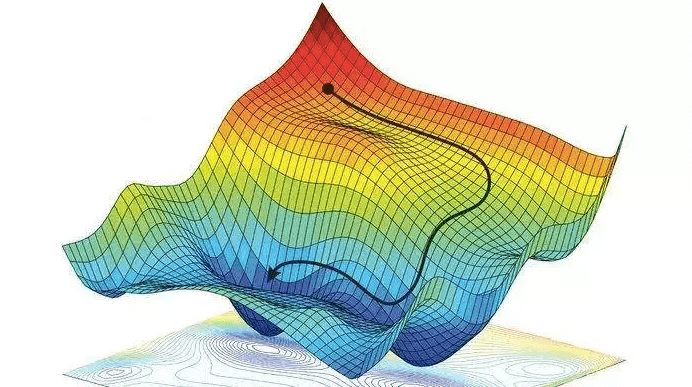

### חישוב אוטומטי של ה`grad.` ע"י _autograd_
נראה כיצד _autograd_  משנה את ערכי ה`grad.`
ניצור שני טנזורים _a_ ו_b_ עם השדה`requires_grad=True` כך נסמן ל_autograd_ שצריך לעקוב אחרי כל השינויים שקוראים בטנזור הזה 

In [9]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

ניצור טנזור אחר _Q_ מ_a_ ו_b_

\begin{align}Q = 3a^3 - b^2\end{align}



In [10]:
Q = 3*a**3 - b**2
Q.grad_fn # An object that contains a link to the tesors that created it

נניח ש_a_ ו_b_ הם פרמטרים של רשת נויירונים כל שהיא ו_Q_ הוא טנזור השגיאה _loss_, באימון הרשת אנחנו רוצים לחשב את גרדיאנט של הפרמטרים, כלומר הנגזרת של הפער בן הטנזור הנוכחי לטנזור השגיאה לפי המשתנים השונים

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}

\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}

כאשר אנחנו קוראים למתודה `()backward.` על _Q_  בצורה אוטמטית _autograd_ מחשבת את הגרדיאנט ומאחסנת אותו בתוך המאפיין (_attribute_)  `grad.` 



אנחנו צריכים בצורה מפורשת להעביר טנזור _gradient_ כארגומנט לתוך `()Q.backward`  בגלל שהוא וקטור, הוא מייצג את הגרדיאנט של _Q_, מכיון ביחס לעצמו - ששווה לטנזור אחדות

\begin{align}\frac{dQ}{dQ} = 1\end{align}

לחלופין ניתן לסכום את אברי _Q_ ואז לקרוא ל`()Q.sum().backward` בלי להעביר את הגרדיאנט של השגיאה

In [11]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

כעת נוכל לראות את הגרדיאנט של כל משתנה ומשתנה אצלו ברשת בצורה מפורשת. למעשה במקרה פשוט זה הגדיאנט הוא הנגזרת 

In [12]:
# check if collected gradients are correct
print(f'{9*a**2} \n --> {a.grad}')
print (f'{-2*b} \n --> {b.grad}')

tensor([36., 81.], grad_fn=<MulBackward0>) 
 --> tensor([36., 81.])
tensor([-12.,  -8.], grad_fn=<MulBackward0>) 
 --> tensor([-12.,  -8.])


### תוספת להרחבה - חישוב וקטור בעזרת _autograd_

מבחינה מתמטית אם נתונה לנו פונקציה על וקטור $\vec{y}=f(\vec{x})$, אזי הגרדיאנט של  $\vec{y}$ ביחס ל $\vec{x}$ היא מטריצת יעקוביאן $J$: כלומר זאת     מטריצת הנגזרות - 
[פה](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/jacobian/v/the-jacobian-matrix) 
 יש תוספת הסבר

\begin{align}J
     =
      \left(\begin{array}{cc}
      \frac{\partial \bf{y}}{\partial x_{1}} &
      ... &
      \frac{\partial \bf{y}}{\partial x_{n}}
      \end{array}\right)
     =
     \left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

באופן כללי  `torch.autograd` זה פונקציה שמאפשרת לנו לחשב את הכפל מטריצות עבור וקטור  $\vec{v}$, נחשב את הכפל
$J^{T}\cdot \vec{v}$

במקרה ש $\vec{v}$ הוא גרדיאנט של פונקציה רגילה  $l=g\left(\vec{y}\right)$:

\begin{align}\vec{v}=
   \left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}\end{align}

ואז ע"י חוק השרשרת של נגזרות  $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot \vec{v}=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\left(\begin{array}{c}
      \frac{\partial l}{\partial y_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial y_{m}}
      \end{array}\right)=\left(\begin{array}{c}
      \frac{\partial l}{\partial x_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial x_{n}}
      \end{array}\right)\end{align}

הוקטור יעקובי הזה הוא מה שאנחנו משתמשים בו בדוגמה למעלה,  
``external_grad`` represents $\vec{v}$.




### איך `autograd` עובד

`autograd` שומר את כל הטנזורים ואת כל הפעולות שעשו עליהם עם התוצאות בגרף מכוון חסר מעגלים (_DAG_), הגרף הזה מורכב 
[מאובייקטי](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function) 
פונקציות מיוחדים
בו העלים הם הטנזורים שנכנסו _input_   ושורש העץ הוא _output_.  
ע"י מעבר משורש העץ עד תחתיתו ניתן לחשב את הגרדיאנט בעזרת חוק השרשרת.


בתהליך ה_forward_ מנגנון ה`autograd` עושה שתי פעולת במקביל: 

- מחשב את התוצאה של ה_input_ הנוכחי כמו תהליך חישוב רגיל.  
- שומר את הפעולות שנעשו בתוך העץ.  

כאשר קוראים ל`()backward.` על התוצאה (וקטור ה_output_ שמהווה ראש העץ) אז _autograd_ הולך לראש העץ ועושה את הפעולות הבאות:

- מחשב את הגדיאנט של כל פונקציה המאוחסנת ב`grad_fn.`
- מכניס את ערך הגרדיאנט לתוך `grad.` של כל וקטור
- באמצעות כלל השרשרת עושה את התהליך הזה כל הדרך עד העלים (שהם ה_input_) 

בתמונה להלן תרשים של עץ _autograd_ פשוט,  
החיצים מסמנים את תהליך ה_forward_ שזה תהליך החישוב של הפונקציות בNN, 
הצמתים בעץ מייצגים את אובייקטי הפונקציות של כל חישוב שנעשה עד שהגענו לתוצאה 
העלים הם הקלט של הפונקציה עלהם עשינו את כל החישובים. 

In [ ]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3*a**3 - b**2
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

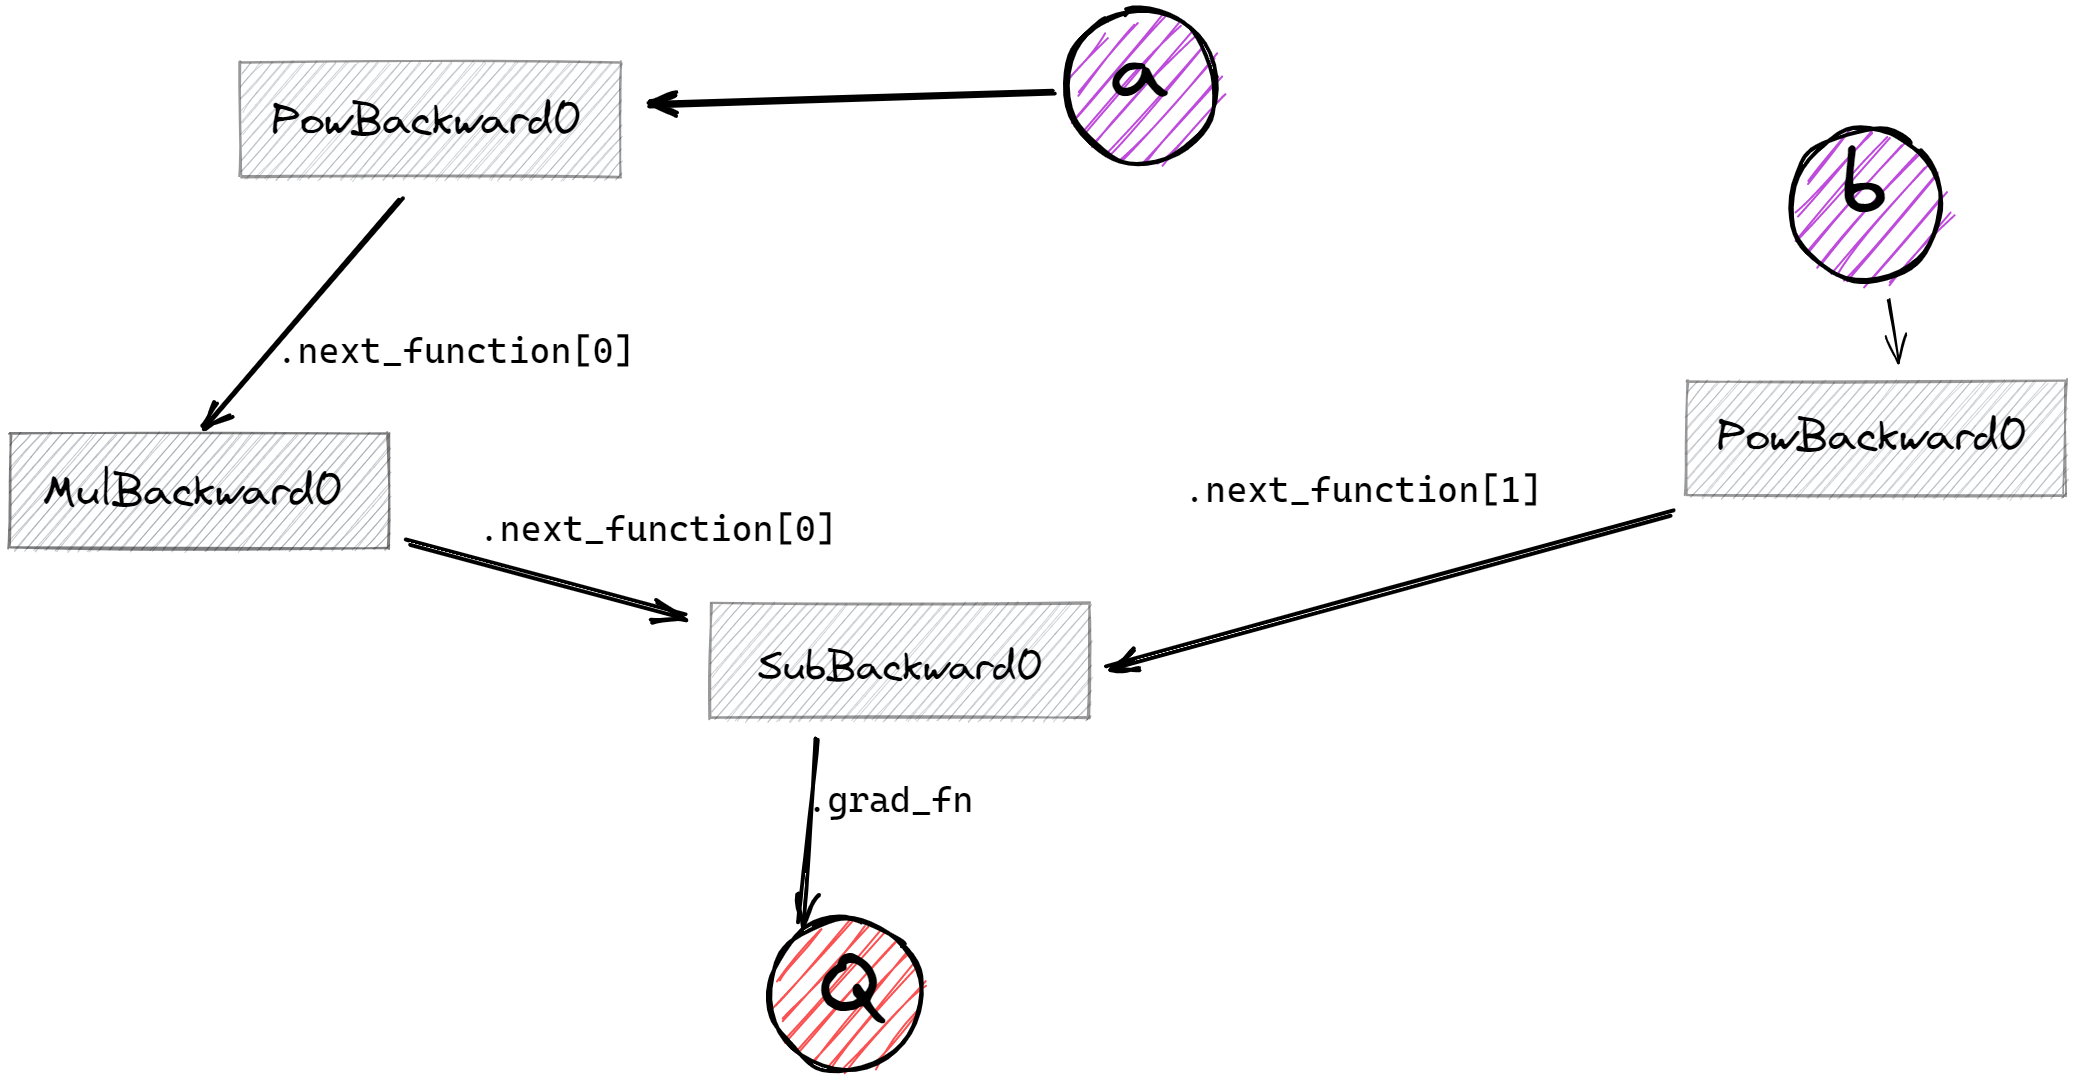

>💡 עץ הפונקציות של _autograd_ נוצר מחדש בכל קריאה של `()backward.` כך אפשר לשנות את הפעולת בכל ריצה.  


### הקפאת פרמטרים _frozen parameters_  

_autograd_ עוקב אחרי כל הטנזורים שהמאפיין `requires_grad.` שלהם מסומן כ`True`. לפעמים יש טנזורים שלא נרצה לחשב להם את הגרדיאנט (ולשנות אותם) בשביל זה אפשר לשנות את הערך ל`False`

כאשר יוצרים טנזורים באופן דיפולטיבי הם `.requires_grad=False` ניתן לשנות זאת במופרש כשמגדירים אותם. 
כאשר יוצרים טנזורים מטנזורים אחרים ע"י פעולות מתמטיות, דיי בכך שטנזור אחד מאלה המרכיבים אותו יהיה  `.requires_grad=True` בשביל שהטנזור שנוצר יהיה ג"כ `.requires_grad=True` 

In [13]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


ברשתות נויירונים _NN_ פרמטרים שלא מחשבים להם את הגרדיאנט נקראים "פרמטרים קפואים" _frozen parameters_. זה שימושי "להקפיא" חלק מהפרמטרים בשביל לשפר את ביצועי המחשב. 

### הכללת ידע _finetuning_
עוד סיבה נפוצה לא לכלול פרמטרים ב_autograd_ היא בשביל הכללת ידע - כלומר לקיחת רשת נויירונים שעובדת ושינוי של חלק מהשכבות שבה למטרה אחרת  [_finetuning_](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
[הכללת ידע](https://www.ai-blog.co.il/2018/12/16/transfer-learning-%D7%94%D7%9B%D7%9C%D7%9C%D7%AA-%D7%99%D7%93%D7%A2/)


בדוגמה להלן נקח את המודל _resnet18_ שכמו שכתבנו לעיל הוא מאומן על זיהוי תמונות ונקפיא את כל הפרמטרים שלו 


In [14]:
from torch import nn, optim

model = torchvision.models.resnet18(pretrained=True)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

נניח שאנחנו רוצים להשתמש במודל _resnet_ בשביל דאטה בייס אחר , עם עשר שכבות?. במודל מסוג כזה השכבה האחרונה שנמצאת ב`model.fc`  היא שיכבה ליניארית והיא זאת שנותנת לכל קלט את התשובה הסופית. כלומר היא מהווה _classifier_. אם נרצה לאמן את המודל שלנו על סוג אתר של דאטא. נוכל להחליף את השיכבה הזאת בשיכבה חדשה שתמיין את התמונה לפי הצרכים שלנו.



In [15]:
model.fc = nn.Linear(512, 10)

כעת כל השכבות מוקפאות, להוציא את השיכבה האחרונה `model.fc`, לכן תהליך האימון ישנה רק את הפרמטרים בשיכבה האחרונה. 

In [16]:
# Optimize only the classifier
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

ניתן לשים לב שלמרות שהכניסו לתוך פונצקיית האופטימיזציה את כל המודל, הפרמטרים היחידים שישונו הם אלה של השיכבה האחרונה שלא הוקפאה.

בצורה מעט שונה ניתן להקפיא פרמטרים ע"י `:()with torch.no_grad` יש עוד פירוט 
[פה](https://pytorch.org/docs/stable/generated/torch.no_grad.html) 



### לקריאה נוספת


-  הסבר מפורט על _autograd_ ושימוש מתקדם בו 
[Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html)
-  הדגמה לשימוש ב_autograd_  
[Simple Grad]()

